First we import all needed libraries and define a function to get the venue location data from foursquare. If you would like to know more about how this function works, have a look at the data.ibynb file. 

In [1]:
!pip install geographiclib
import pandas as pd
import numpy as np
import folium
import matplotlib.colors as colors
import requests as req
import seaborn as sns
import matplotlib.pyplot as plt
import json as js
from matplotlib import cm
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84
import zipfile
import getpass
import folium.plugins as fplugins
import os
import ast
import collections

def get_venues(lat_center,long_center,name,ID,SECRET,rad=10000,max_lvl=5):
    angles=[0,60,120,180,240,300]
    lvl=0
    VERSION = '20180605' # Foursquare API version
    df_venues=pd.DataFrame()
    df_items=pd.DataFrame()
    df_requests=pd.DataFrame(columns=['lati','lngi','lvl','items','dist'])
    df_requests=df_requests.append({'lati':lat_center, 'lngi':long_center, 'lvl': lvl, 'items':100, 'dist':0}, ignore_index=True)
    requests=1
    while lvl < max_lvl:
        df=df_requests[(df_requests['lvl']==lvl) & (df_requests['items']>99)].reset_index()
        for i in range(len(df)):
            df_requests=df_requests.append({'lati':df.loc[i,'lati'], 'lngi':df.loc[i,'lngi'], 'lvl': lvl+1,'dist':0}, ignore_index=True)
            for angle in angles:
                geo=geod.Direct(df.loc[i,'lati'],df.loc[i,'lngi'],angle,rad/2**(lvl)*0.866)
                dist=geod.Inverse(lat_center,long_center,geo['lat2'],geo['lon2'])['s12']
                #check if circle is within the initial search radius
                if dist< rad+rad/2**(lvl+1):
                    df_requests=df_requests.append({'lati':geo['lat2'], 'lngi':geo['lon2'], 'lvl': lvl+1, 'dist':dist}, ignore_index=True)
        lvl=lvl+1
        #drop duplicate circles
        #df_requests.drop_duplicates(subset=['lati','lngi','lvl'],inplace=True)
        #the drop duplicate method does not work since the position of similar circles is not exactly equal.
        #Therefore we measure the distance between every point and drop one of the points if the distance is below 100m
        droplist=[True]*len(df_requests)
        for i in range(requests, requests+len(df_requests[df_requests['lvl']==lvl])):
            df_requests=df_requests.reset_index(drop=True)
            for j in range(requests, requests+len(df_requests[df_requests['lvl']==lvl])):
                if (i!= j):
                    dist=geod.Inverse(df_requests.loc[i,'lati'],df_requests.loc[i,'lngi'],df_requests.loc[j,'lati'],df_requests.loc[j,'lngi'])['s12']
                    if (dist < 100) & droplist[i]==True:
                        droplist[j]=False
        df_requests=df_requests[droplist]
        df_requests=df_requests.reset_index(drop=True)
        for i in range(requests, requests+len(df_requests[df_requests['lvl']==lvl])):
            url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(ID, SECRET, df_requests.loc[i,'lati'], df_requests.loc[i,'lngi'], VERSION, rad/2**df_requests.loc[i,'lvl'],100)
            results = req.get(url).json()
            requests=requests +1
            #print(requests,url,results['response'])
            if results['response'] == {}:
                print('empty response')
            else:
                nvenues=len(results['response']['groups'][0]['items'])
                df_requests.loc[i,'items']=nvenues
                items = results['response']['groups'][0]['items']
                df_items= pd.json_normalize(items)
                if len(df_items)>0:
                    #if all returned locations are in neighboring cities we invert the nvenues. This way they are always below 100 and the place will not be searched again
                    df_items['venue.location.formattedAddress']=df_items['venue.location.formattedAddress'].apply(', '.join)
                    if len(df_items[df_items['venue.location.formattedAddress'].str.contains(name)])<1:
                        df_requests.loc[i,'items']=-nvenues
                    df_venues=df_venues.append(df_items)
    #df_venues=df_venues[df_venues['venue.location.formattedAddress'].str.contains(name)]]
    print(name + ': made ' +  str(requests)+ ' requests, obtained ' + str(len(df_venues)) + ' venues.')
    print(str(len(df_requests[(df_requests['items']==100)&(df_requests['lvl']==max_lvl)])) + ' highest level requests with 100 items (or more)')
    return df_venues.reset_index(drop=True), df_requests

We load the simplemaps file, which contains the location data of the cities of the world and set up the foursquare cresedentials:

In [2]:
#foursquare set-up
CLIENT_ID = getpass.getpass('ID:')
CLIENT_SECRET = getpass.getpass('SECRET:')


ID:········
SECRET:········


In [3]:
#url_zip = urllib.request.urlopen("http://www.unece.org/fileadmin/DAM/cefact/locode/loc162txt.zip")
!wget -O simplemaps.zip https://simplemaps.com/static/data/world-cities/basic/simplemaps_worldcities_basicv1.6.zip
 
zf = zipfile.ZipFile('simplemaps.zip')
df_city = pd.read_csv(zf.open('worldcities.csv'))
#remove all cities with fewer than 100000 population
df_city=df_city[df_city['population']>500000]
#make city-name index
df_city = df_city.set_index('city_ascii')

#df_city.loc['Bremen']

--2020-08-24 18:33:35--  https://simplemaps.com/static/data/world-cities/basic/simplemaps_worldcities_basicv1.6.zip
Resolving simplemaps.com (simplemaps.com)... 104.26.12.95, 104.26.13.95, 172.67.71.113, ...
Connecting to simplemaps.com (simplemaps.com)|104.26.12.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1505132 (1,4M) [application/zip]
Saving to: ‘simplemaps.zip’

simplemaps.zip      100%[===================>]   1,43M  1,67MB/s    in 0,9s    

2020-08-24 18:33:36 (1,67 MB/s) - ‘simplemaps.zip’ saved [1505132/1505132]



Let us define a list that contains all the cities we would like to explore, run the function on each of the cities and store the obtained data in .csv files so we don't have to make this large amount of foursquare requests again.

In [51]:
CityList=['Berlin','London','Paris']
venues = {}
requests = {}
for city in CityList:
    if os.path.isfile('./'+ city+'_venues.csv') and os.path.isfile('./'+ city+'_requests.csv'):
        venues[city]=pd.read_csv('./'+ city+'_venues.csv')
        requests[city]=pd.read_csv('./'+ city+'_requests.csv')
        print(city + ': read ' +  str(len(requests[city]))+ ' requests, obtained ' + str(len(venues[city])) + ' venues.')
    else:
        print('#')
        lat_center=df_city.loc[city,'lat']
        long_center=df_city.loc[city,'lng']   
        venues[city], requests[city] = get_venues(lat_center,long_center,city,CLIENT_ID,CLIENT_SECRET,max_lvl=5)
        venues[city].to_csv(city+'_venues.csv')
        requests[city].to_csv(city+'_requests.csv')

Berlin: read 347 requests, obtained 17383 venues.
London: read 495 requests, obtained 27380 venues.
Paris: read 357 requests, obtained 20083 venues.


In [52]:
n=0

map = folium.Map(location=[df_city.loc[CityList[n],'lat'], df_city.loc[CityList[n],'lng']], zoom_start=11,control_scale = True)

colors_array = cm.hot(np.linspace(0, 0.8, 6))
palette = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, lvl in zip(requests[CityList[n]]['lati'], requests[CityList[n]]['lngi'], requests[CityList[n]]['lvl']):
        folium.vector_layers.Circle(
            [lat, lng],
            radius=10000/2**lvl,
            color=palette[int(lvl)],
            fill=False,
            fill_opacity=0,
            parse_html=False).add_to(map)
      
map

In [57]:
def get_category_type(row):
    categories_list = ast.literal_eval(row['venue.categories'])   
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']    

venues2={}
unique=[]
for city in CityList:
    venues2[city]=venues[city].drop_duplicates(subset=['referralId'])
    venues2[city]=venues2[city][venues2[city]['venue.location.formattedAddress'].str.contains(city)]
    venues2[city]['venue.name']=venues2[city]['venue.name'].str.replace('`',"'")
    venues2[city]['category']=venues2[city].apply(get_category_type, axis=1)
    venues2[city]=venues2[city].drop_duplicates(subset=['venue.name','category'])
    #unique=list(set().union(unique,venues2[city]['category'].unique()))


In [58]:
if os.path.isfile("./categories.json"):
    with open("categories.json", "r") as infile:
        results = js.load(infile)
else:    
    with open("categories.json", "w") as outfile:
        VERSION = '20180605'
        url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION,)
        results = req.get(url).json()
        js.dump(results, outfile)

In [59]:
df_items= pd.DataFrame()
subcategories={}
for i in range(3,5):
    df_items= df_items.append(pd.json_normalize(results['response']['categories'][i]['categories']))
    for j in range(len(results['response']['categories'][i]['categories'])):
        df_items= df_items.append(pd.json_normalize(results['response']['categories'][i]['categories'][j]['categories']))
        if results['response']['categories'][i]['categories'][j]['categories'] != []:
            for k in range(len(results['response']['categories'][i]['categories'][j]['categories'])):
                subcategories.update({results['response']['categories'][i]['categories'][j]['categories'][k]['name'] : results['response']['categories'][i]['categories'][j]['name']})
                df_items= df_items.append(pd.json_normalize(results['response']['categories'][i]['categories'][j]['categories'][k]['categories']))
                if results['response']['categories'][i]['categories'][j]['categories'] != []:
                    for l in range(len(results['response']['categories'][i]['categories'][j]['categories'][k]['categories'])):
                        subcategories.update({results['response']['categories'][i]['categories'][j]['categories'][k]['categories'][l]['name'] : results['response']['categories'][i]['categories'][j]['name']})
        else:
             subcategories.update({results['response']['categories'][i]['categories'][j]['name'] : results['response']['categories'][i]['categories'][j]['name']})
categories=df_items['name'].to_list()
categories

['Afghan Restaurant',
 'African Restaurant',
 'American Restaurant',
 'Armenian Restaurant',
 'Asian Restaurant',
 'Australian Restaurant',
 'Austrian Restaurant',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bangladeshi Restaurant',
 'Belgian Restaurant',
 'Bistro',
 'Breakfast Spot',
 'Bubble Tea Shop',
 'Buffet',
 'Burger Joint',
 'Cafeteria',
 'Café',
 'Cajun / Creole Restaurant',
 'Caribbean Restaurant',
 'Caucasian Restaurant',
 'Coffee Shop',
 'Comfort Food Restaurant',
 'Creperie',
 'Czech Restaurant',
 'Deli / Bodega',
 'Dessert Shop',
 'Diner',
 'Donut Shop',
 'Dumpling Restaurant',
 'Dutch Restaurant',
 'Eastern European Restaurant',
 'English Restaurant',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Fish & Chips Shop',
 'Fondue Restaurant',
 'Food Court',
 'Food Stand',
 'Food Truck',
 'French Restaurant',
 'Fried Chicken Joint',
 'Friterie',
 'Gastropub',
 'German Restaurant',
 'Gluten-free Restaurant',
 'Greek Restaurant',
 'Halal Restaurant',
 'Hawaiian Restaurant',
 '

In [ ]:
"""
categories=['Coffee Shop', 'Caucasian Restaurant', 'Cocktail Bar','Ice Cream Shop', 'Ramen Restaurant', 'Bistro',
            'Sandwich Place', 'Bakery','Café', 'Falafel Restaurant', 'Gourmet Shop','Vegetarian / Vegan Restaurant',
            'Schnitzel Restaurant', 'Beer Bar', 'Seafood Restaurant', 'Wine Bar', 'Italian Restaurant', 
            'Juice Bar', 'Empanada Restaurant', 'Korean Restaurant', 'Breakfast Spot', 'Karaoke Bar', 
            'Austrian Restaurant', 'Dumpling Restaurant', 'Spanish Restaurant', 'Gastropub', 'Trattoria/Osteria',
            'German Restaurant', 'Pastry Shop', 'Tapas Restaurant', 'Indian Restaurant', 'Greek Restaurant', 
            'Hookah Bar', 'Turkish Restaurant', 'Argentinian Restaurant', 'Pizza Place', 'Restaurant', 'Mexican Restaurant',
            'Chinese Restaurant', 'Gas Station', 'Paintball Field', 'American Restaurant', 'Asian Restaurant', 'Bar',
            'Vietnamese Restaurant', 'Steakhouse', 'Sports Bar', 'Donut Shop', 'Beer Garden', 'Brewery', 'Candy Store', 
            'Fish & Chips Shop', 'Thai Restaurant', 'Modern European Restaurant', 'Deli / Bodega', 'Tea Room', 
            'Syrian Restaurant', 'Eastern European Restaurant', 'Taverna', 'Doner Restaurant', 'African Restaurant',
            'Snack Place', 'Whisky Bar', 'French Restaurant', 'Dessert Shop', 'Street Food Gathering', 
            'Portuguese Restaurant', 'Wine Shop', 'Peruvian Restaurant', 'Noodle House', 'Bagel Shop',
            'Mediterranean Restaurant', 'Japanese Restaurant', 'Middle Eastern Restaurant', 'Sushi Restaurant',
            'Swabian Restaurant', 'Persian Restaurant', 'Beer Store', 'Food Court', 'Pub', 'Burger Joint', 
            'Burrito Place', 'Israeli Restaurant', 'Chocolate Shop', 'Pakistani Restaurant', 'Dim Sum Restaurant', 
            'Salad Place', 'Fried Chicken Joint', 'Currywurst Joint', 'Halal Restaurant', 'Piano Bar', 'Hotel Bar', 
            'Diner', 'Russian Restaurant', 'Kumpir Restaurant', 'Creperie', 'Hot Dog Joint', 'New American Restaurant', 
            'Ethiopian Restaurant', 'Bubble Tea Shop', 'BBQ Joint', 'Food & Drink Shop', 'Fast Food Restaurant', 
            'Irish Pub', 'Food Truck', 'Latin American Restaurant', 'Yemeni Restaurant', 'Turkish Home Cooking Restaurant', 
            'Szechuan Restaurant', 'Coffee Roaster', 'Pet Café', 'Soup Place', 'Pie Shop', 'Swiss Restaurant',
            'Brasserie', 'Beach Bar', 'Cupcake Shop', 'Cheese Shop', 'Kebab Restaurant', 'Food Stand', 'Kurdish Restaurant',
            'Lebanese Restaurant', 'Indonesian Restaurant','Brazilian Restaurant', 'South American Restaurant',
            'Distillery', 'Gaming Cafe', 'Venezuelan Restaurant', 'Kofte Place', 'Comfort Food Restaurant', 
            'Colombian Restaurant', 'Scandinavian Restaurant', 'Tibetan Restaurant', 'Shawarma Place',
            'Caribbean Restaurant', 'Cuban Restaurant', 'Frozen Yogurt Shop', 'Mongolian Restaurant', 
            'Palatine Restaurant', 'Souvlaki Shop', 'Filipino Restaurant', 'Cafeteria', 'Cantonese Restaurant', 
            'Jewish Restaurant', 'Hawaiian Restaurant', 'Bavarian Restaurant', 'Polish Restaurant', 'Moroccan Restaurant',
            'Food', 'Sri Lankan Restaurant', 'Franconian Restaurant', 'Silesian Restaurant', 'South Indian Restaurant', 
            'Buffet', 'Bosnian Restaurant', 'Cigkofte Place', 'Bratwurst Joint', 'Fondue Restaurant','Smoothie Shop', 
            'Taiwanese Restaurant', 'Food Service','Modern Greek Restaurant']

len(categories)

"""

In [60]:

venues3={}
for city in CityList:
    venues3[city]=venues2[city][venues2[city]['category'].isin(categories)]
    venues3[city]=venues3[city].reset_index(drop=True)
n=0                                         
map2 = folium.Map(location=[df_city.loc[CityList[n],'lat'], df_city.loc[CityList[n],'lng']], zoom_start=11,control_scale = True)

venues_cluster = fplugins.MarkerCluster().add_to(map2)

for lat, lng, label, cat in zip(venues3[CityList[n]]['venue.location.lat'], venues3[CityList[n]]['venue.location.lng'], venues3[CityList[n]]['venue.name'].str.replace('`',"'"),venues3[CityList[n]]['category']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=cat + ": " + label,
    ).add_to(venues_cluster)
    
map2

In [61]:
for city in CityList:
    venues3[city]['main_category']=venues3[city]['category'].map(subcategories)
    venues3[city]['venue.location.lng.cor']=venues3[city]['venue.location.lng']*np.cos(np.deg2rad(venues3[city]['venue.location.lat']))

venues3['Berlin'][['venue.location.lng.cor','venue.location.lng','venue.location.lat']]

venue.location.lng.cor  venue.location.lng  venue.location.lat
0                   8.153906           13.401928           52.525168
1                   8.150227           13.395808           52.524928
2                   8.156886           13.406614           52.524469
3                   8.157718           13.407440           52.522697
4                   8.150169           13.395542           52.524365
...                      ...                 ...                 ...
4149                8.096959           13.305146           52.514660
4150                8.101508           13.308969           52.502597
4151                8.096225           13.300460           52.503160
4152                8.100824           13.307038           52.499930
4153                8.095391           13.301111           52.509843

[4154 rows x 3 columns]

In [62]:
from sklearn.cluster import DBSCAN


for city in CityList:
    ClusterData = venues3[city][['venue.location.lat','venue.location.lng.cor']]
    db = DBSCAN(eps=0.0010, min_samples=10).fit(ClusterData)
    labels = db.labels_
    unique_labels = set(labels)
    print(city, unique_labels)
    venues3[city]['cluster_label']=labels

Berlin {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, -1}
London {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, -1}
Paris {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, -1}


In [63]:
n=0
nlabels=len(venues3[CityList[n]]['cluster_label'].unique())-1
colors_array = cm.hsv(np.linspace(0, 1, nlabels))
palette = [colors.rgb2hex(i) for i in colors_array]



map3 = folium.Map(location=[df_city.loc[CityList[n],'lat'], df_city.loc[CityList[n],'lng']], zoom_start=11,control_scale = True)
for i in range(0,nlabels):
    df=venues3[CityList[n]][venues3[CityList[n]]['cluster_label']==i]
    for lat, lng, name in zip(df['venue.location.lat'], df['venue.location.lng'],df['venue.name']):
        label = folium.Popup(name, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=str(i) + ": " + name,
            color=palette[i],
            fill=True,
            fill_color=palette[i],
            fill_opacity=1,
            parse_html=False).add_to(map3)

map3


In [64]:
venues_oh={}
venues_grouped={}
for city in CityList:
    venues_oh[city]=venues3[city][['cluster_label','venue.location.lat','venue.location.lng']].join(pd.get_dummies(venues3[city]['category'], prefix="", prefix_sep=""))
    venues_oh[city]=venues_oh[city][venues_oh[city]['cluster_label']!=-1]
    venues_oh[city].reset_index(drop=True)
    for cat in categories:
        if cat not in venues_oh[city]:
            venues_oh[city][cat]=0.0
    venues_grouped[city] = venues_oh[city].groupby('cluster_label').mean().reset_index()
    venues_grouped[city]
venue_clusters=pd.DataFrame()
for city in CityList:
    df=venues_grouped[city]
    df['city']=city
    venue_clusters=venue_clusters.append(df)
#venue_clusters=venue_clusters.fillna(0).reset_index(drop=True)
venue_clusters.reset_index(drop=True)


cluster_label  venue.location.lat  venue.location.lng  \
0                0           52.527045           13.408519   
1                1           52.526410           13.393718   
2                2           52.537439           13.421278   
3                3           52.531813           13.432123   
4                4           52.500711           13.418363   
..             ...                 ...                 ...   
220             73           48.867016            2.358621   
221             74           48.853176            2.376055   
222             75           48.868317            2.291788   
223             76           48.872527            2.302601   
224             77           48.846994            2.285986   

     African Restaurant  American Restaurant  Argentinian Restaurant  \
0                   0.0                  0.0                     0.0   
1                   0.0                  0.0                     0.0   
2                   0.0                  0.0                     0.0   
3                   0.0                  0.0                     0.0   
4                   0.0                  0.0                     0.0   
..                  ...                  ...                     ...   
220                 0.0                  0.0                     0.1   
221                 0.0                  0.0                     0.0   
222                 0.0                  0.0                     0.0   
223                 0.0                  0.0                     0.0   
224                 0.0                  0.0                     0.0   

     Asian Restaurant  Austrian Restaurant  BBQ Joint  Bagel Shop  ...  \
0            0.000000             0.000000        0.0    0.000000  ...   
1            0.000000             0.000000        0.0    0.000000  ...   
2            0.068966             0.000000        0.0    0.000000  ...   
3            0.000000             0.055556        0.0    0.000000  ...   
4            0.000000             0.000000        0.0    0.025641  ...   
..                ...                  ...        ...         ...  ...   
220          0.000000             0.000000        0.0    0.000000  ...   
221          0.000000             0.000000        0.0    0.000000  ...   
222          0.000000             0.000000        0.0    0.000000  ...   
223          0.100000             0.000000        0.0    0.000000  ...   
224          0.000000             0.000000        0.0    0.000000  ...   

     West-Ukrainian Restaurant  Night Market  Other Nightlife  Strip Club  \
0                          0.0           0.0              0.0         0.0   
1                          0.0           0.0              0.0         0.0   
2                          0.0           0.0              0.0         0.0   
3                          0.0           0.0              0.0         0.0   
4                          0.0           0.0              0.0         0.0   
..                         ...           ...              ...         ...   
220                        0.0           0.0              0.0         0.0   
221                        0.0           0.0              0.0         0.0   
222                        0.0           0.0              0.0         0.0   
223                        0.0           0.0              0.0         0.0   
224                        0.0           0.0              0.0         0.0   

     Champagne Bar  Ice Bar  Rooftop Bar  Sake Bar  Tiki Bar    city  
0              0.0      0.0          0.0       0.0       0.0  Berlin  
1              0.0      0.0          0.0       0.0       0.0  Berlin  
2              0.0      0.0          0.0       0.0       0.0  Berlin  
3              0.0      0.0          0.0       0.0       0.0  Berlin  
4              0.0      0.0          0.0       0.0       0.0  Berlin  
..             ...      ...          ...       ...       ...     ...  
220            0.0      0.0          0.0       0.0       0.0   Paris  
221          

In [104]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# set number of clusters
kclusters = 10

df=venue_clusters[categories]

pca=PCA(n_components=50)
pca.fit(df)

venue_clusters_pca=pca.transform(df)

# run k-means clustering

kmeans = KMeans(n_clusters=kclusters, random_state=1, n_init=100).fit(venue_clusters_pca)

# check cluster labels generated for each row in the dataframe
venue_clusters['cluster_cluster_label']=kmeans.labels_
#venue_clusters[categories]
print(np.argpartition(abs( pca.components_[0] ), -4)[-4:])
print(abs(pca.components_[0][41]))
print(sum(pca.explained_variance_ratio_))

[22 18 54 41]
0.9243220235917715
0.9326806750901256


In [84]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['cluster_label','cluster_cluster_label','venue.location.lat','venue.location.lng']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['cluster_label'] = venue_clusters['cluster_label']
venues_sorted['cluster_cluster_label'] = venue_clusters['cluster_cluster_label']
venues_sorted['venue.location.lat'] = venue_clusters['venue.location.lat']
venues_sorted['venue.location.lng'] = venue_clusters['venue.location.lng']

for ind in range(len(venue_clusters)):
    venues_sorted.iloc[ind, 4:] = return_most_common_venues(venue_clusters.drop(['cluster_cluster_label','cluster_label','venue.location.lat','venue.location.lng','city'], 1).iloc[ind, :], num_top_venues)
#venues_sorted.head(20)

frequent_categories=venues_sorted[['1st Most Common Venue','2nd Most Common Venue', '3rd Most Common Venue']].stack().unique().tolist()
frequent_categories=frequent_categories

cc_count=venue_clusters.groupby('cluster_cluster_label').count().iloc[:,0].to_list()
cc_count_city={}

for city in CityList:
    cc_count_city[city]=venue_clusters[venue_clusters['city']==city].groupby('cluster_cluster_label').count().iloc[:,0].reindex(list(range(0,kclusters)),fill_value=0).tolist()


venues_avg=venue_clusters.drop(['cluster_label','venue.location.lat','venue.location.lng','city','cluster_cluster_label'],axis=1).mean()
venues_avg

#cc_count_city['Berlin']

African Restaurant        0.002680
American Restaurant       0.004810
Argentinian Restaurant    0.004145
Asian Restaurant          0.015529
Austrian Restaurant       0.002319
                            ...   
Champagne Bar             0.001211
Ice Bar                   0.000000
Rooftop Bar               0.000000
Sake Bar                  0.000000
Tiki Bar                  0.000404
Length: 369, dtype: float64

In [74]:
venues_sorted[venues_sorted['cluster_cluster_label']==0]

cluster_label  cluster_cluster_label  venue.location.lat  \
37             37                      0           48.857953   
53             53                      0           48.887606   
54             54                      0           48.884252   
55             55                      0           48.886878   
61             61                      0           48.854330   
69             69                      0           48.866539   
72             72                      0           48.874424   
75             75                      0           48.868317   

    venue.location.lng 1st Most Common Venue 2nd Most Common Venue  \
37            2.301801     French Restaurant                Bakery   
53            2.334750     French Restaurant    Italian Restaurant   
54            2.340029     French Restaurant    Italian Restaurant   
55            2.340435     French Restaurant        Ice Cream Shop   
61            2.367540     French Restaurant              Wine Bar   
69            2.327130     French Restaurant             Hotel Bar   
72            2.372395     French Restaurant                Bistro   
75            2.291788     French Restaurant    Italian Restaurant   

   3rd Most Common Venue          4th Most Common Venue  5th Most Common Venue  
37                Bistro             Italian Restaurant                   Café  
53   American Restaurant                         Bakery               Wine Bar  
54          Burger Joint                         Bakery                    Bar  
55                  Café                 Sandwich Place                    Bar  
61           Coffee Shop             Italian Restaurant   Brazilian Restaurant  
69          Burger Joint  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
72             Gastropub         Argentinian Restaurant           Cocktail Bar  
75                  Café                      Brasserie               Tiki Bar

/home/drobs/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1440x360 with 0 Axes>

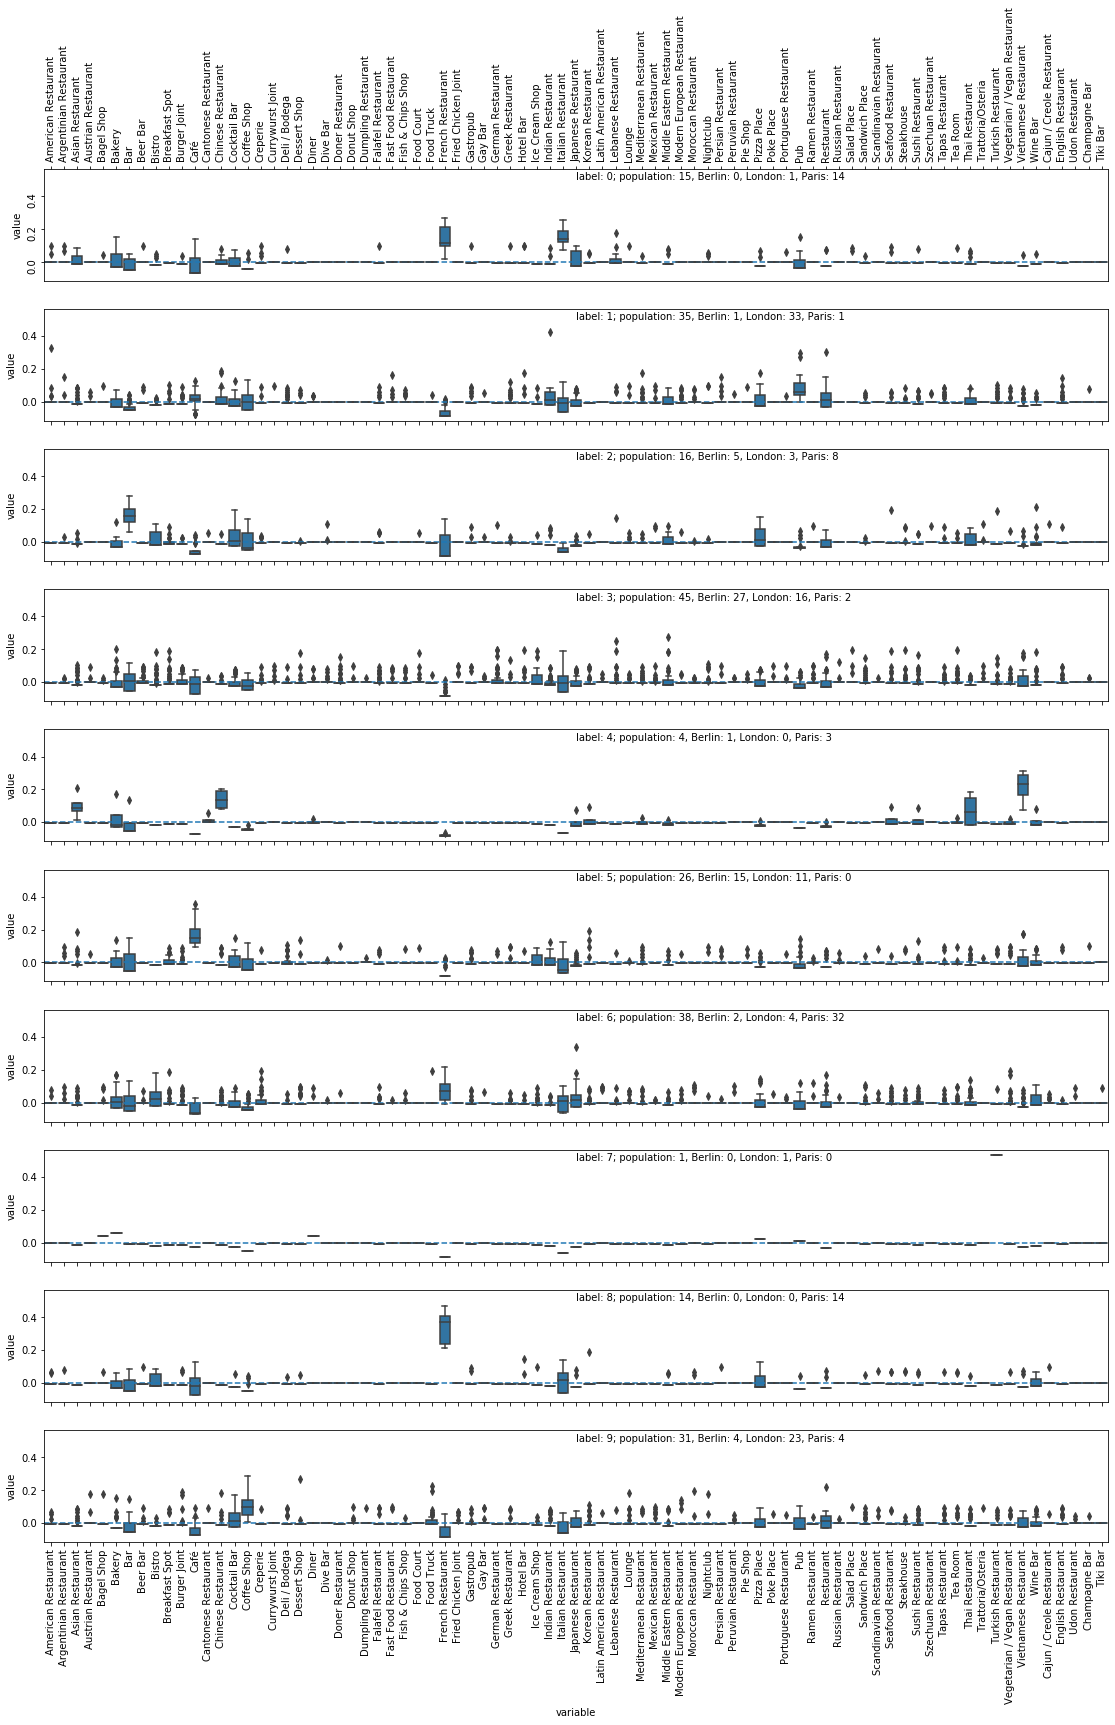

In [85]:
plt.figure(figsize=(20,5))
df=venue_clusters.drop(['cluster_label','venue.location.lat','venue.location.lng','city'],axis=1)
for col in df.drop(['cluster_cluster_label'],axis=1).columns:
    df[col]=df[col]-venues_avg[col]
df=df.melt(id_vars='cluster_cluster_label')
df=df[df['variable'].isin(frequent_categories)]
df

grid= sns.FacetGrid(df, row='cluster_cluster_label', height=2, aspect=8,despine=False)
#for i in df['cluster_cluster_label'].unique():
#    df2=df[df['cluster_cluster_label']==i]
grid.map(sns.boxplot,'variable','value')
grid.set_xticklabels(rotation=90)
grid.set_titles()
#grid.xaxis.tick_top()

for i in range(len(grid.axes)):
    grid.axes[i][0].axhline(0, ls='--')
    grid.axes[i][0].set_title("")
    text = "label: " + str(i) + "; population: " + str(cc_count[i])
    for city in CityList:
        text =text + ", " + city + ": " + str(cc_count_city[city][i])
    grid.axes[i][0].text(0.5,0.9, text, transform=grid.axes[i][0].transAxes)
    if i==0:
        grid.axes[i][0].xaxis.set_ticks_position("top")
        grid.axes[i][0].tick_params(labelrotation=90)

In [167]:

df=venue_clusters.drop(['cluster_label','venue.location.lat','venue.location.lng','city'],axis=1).transpose()
df=df[df.index.isin(frequent_categories)].transpose()
df
sns.pairplot(df)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fdf865f8378> (for post_execute):


KeyboardInterrupt: 

variable     value
index                                           
Asian Restaurant                     0  0.012296
Austrian Restaurant                  0  0.015909
Bagel Shop                           0  0.002934
Bakery                               0  0.038679
Bar                                  0  0.145430
...                                ...       ...
Trattoria/Osteria                    5  0.000000
Turkish Restaurant                   5  0.015883
Vegetarian / Vegan Restaurant        5  0.007555
Vietnamese Restaurant                5  0.051699
Wine Bar                             5  0.000000

[312 rows x 2 columns]

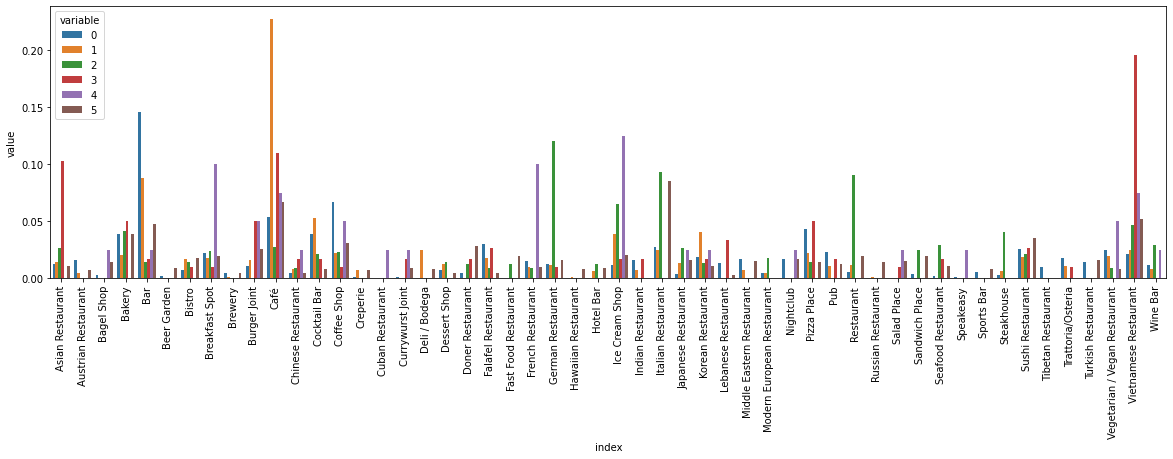

In [37]:
df=venue_clusters.groupby('cluster_cluster_label').mean().reset_index().drop(['cluster_cluster_label','cluster_label','venue.location.lat','venue.location.lng'],axis=1).transpose()
#df2=df.stack()
df=df[df.index.isin(frequent_categories)]
df2=pd.melt(df.reset_index(),id_vars='index')
df2=df2.set_index('index')
plt.figure(figsize=(20,5))
ax=sns.barplot(x=df2.index,y=df2['value'],hue=df2['variable'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#print()
df2

In [ ]:
sns.bars()